In [94]:
import torch, math

# Shakespear dataset
with open('shakespear_dat.txt', 'r') as f:
    dat = f.read()
    
print("Length of dataset: ", len(dat))
chars = sorted(list(set(dat)))
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda i: ''.join([itos[l] for l in i])
data = torch.tensor(encode(dat))

# train test split
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

Length of dataset:  1115393


In [2]:
# Hyperparameters
LiGO_bool = True
device = torch.device('cuda:1')
block_size = 8
batch_size = 2048
val_batch_size = 2048
vocab_size = len(chars)
emb_size = 32
new_emb_size = 64
num_small_layers = 4
multi_heads = 2
num_large_layers = 8

In [3]:
torch.manual_seed(1337)
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size if split=='train' else val_batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

In [4]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [5]:
class AttentionHead(torch.nn.Module):
    def __init__(self, big=False):
        super(AttentionHead, self).__init__()
        self.k = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size, bias=False)
        self.q = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size, bias=False)
        self.v = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size)))
    def forward(self, e):
        keys = self.k(e)
        queries = self.q(e)
        values = self.v(e)
        ret = keys @ queries.transpose(1, 2)*(1.0/math.sqrt(keys.size(-1)))
        ret = torch.masked_fill(ret, self.tril==0, -torch.inf)
        ret = torch.softmax(ret, 2)
        ret = ret @ values
        return ret

In [6]:
class MultiHead(torch.nn.Module):
    def __init__(self, big=False):
        super(MultiHead, self).__init__()
        self.head1 = AttentionHead(big)
        self.head2 = AttentionHead(big)
        self.mh_lin = torch.nn.Linear(multi_heads*(new_emb_size if big else emb_size), new_emb_size if big else emb_size, bias=False)
        self.drop = torch.nn.Dropout(0.1)
    def forward(self, inp):
        x1 = self.head1(inp)
        x2 = self.head2(inp)
        return self.mh_lin(self.drop(torch.cat([x1,x2], dim=2))).relu()


In [7]:
class Block(torch.nn.Module):
    def __init__(self, big=False):
        super(Block, self).__init__()
        self.multihead = MultiHead(big)
        self.l_norm_1 = torch.nn.LayerNorm(new_emb_size if big else emb_size)
        self.l_norm_2 = torch.nn.LayerNorm(new_emb_size if big else emb_size)
        self.ffn = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size)
        self.drop = torch.nn.Dropout(0.1)
    def forward(self, inp):
        m = self.l_norm_1(inp + self.multihead(inp))
        m = self.l_norm_2(m + self.ffn(self.drop(m)).relu())
        return m

In [8]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, emb_size)
        self.pe = PositionalEncoding(d_model=emb_size)
        self.block1 = Block()
        self.block2 = Block()
        self.block3 = Block()
        self.block4 = Block()
        self.f_lin = torch.nn.Linear(emb_size, vocab_size)
        self.drop = torch.nn.Dropout(0.1)
    def forward(self, inp):
        e = self.embedding(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        r = self.f_lin(self.drop(m))
        return r

In [9]:
model = Model().to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [10]:
@torch.no_grad()
def validate(mdl):
    mdl.eval()
    vx, vy = get_batch('val')
    out = mdl(vx.to(device))
    return loss(out.view(-1, 65), vy.view(-1).to(device)).item()

In [11]:
@torch.enable_grad()
def train(mdl, optim, epochs):
    ind = 0
    train_curve = []
    for _ in range(epochs):
        mdl.train()
        optim.zero_grad()
        x, y = get_batch('train')
        out = mdl(x.to(device))
        l = loss(out.view(-1, 65), y.view(-1).to(device))
        l.backward()
        optim.step()
        ind += 1
        if ind%10 == 0:
            v = validate(mdl)
            if ind%100==0:
                print(l.item())
                print(f"Validation: {v}")
            train_curve.append(v)
    return train_curve

In [12]:
small_model_curve = train(model, optimizer, 500)

In [14]:
k_params = torch.empty((0,emb_size*emb_size)).to(device)
q_params = torch.empty((0,emb_size*emb_size)).to(device)
v_params = torch.empty((0,emb_size*emb_size)).to(device)
lin_params = torch.empty((0, 2*emb_size*emb_size)).to(device)
ffn_w_params = torch.empty((0, emb_size*emb_size)).to(device)
ffn_b_params = torch.empty((0, emb_size)).to(device)
l_norm_w_params = torch.empty((0, emb_size)).to(device)
l_norm_b_params = torch.empty((0, emb_size)).to(device)
for i in model.state_dict():
    if '.k.' in i:
        k_params = torch.cat((k_params, model.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.q.' in i:
        q_params = torch.cat((q_params, model.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.v.' in i:
        v_params = torch.cat((v_params, model.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.mh_lin' in i:
        lin_params = torch.cat((lin_params, model.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'weight' in i:
        ffn_w_params = torch.cat((ffn_w_params, model.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'bias' in i:
        ffn_b_params = torch.cat((ffn_b_params, model.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'weight' in i:
        l_norm_w_params = torch.cat((l_norm_w_params, model.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'bias' in i:
        l_norm_b_params = torch.cat((l_norm_b_params, model.state_dict()[i].flatten().view(1,-1)), dim = 0)

In [15]:
class FusedEmbedding(torch.nn.Module):
    def __init__(self, emb_params, static=True, width=False, width_static=True):
        super(FusedEmbedding, self).__init__()
        self.static = static
        self.width_static = width_static
        self.width=width
        if static:
            if width:
                if width_static:
                    self.emb_params = torch.cat((emb_params, emb_params)).view(vocab_size, -1)
                else:
                    self.emb_params = emb_params.view(vocab_size, -1)
                    self.width_w = torch.nn.Linear(emb_size, new_emb_size, bias=False)
            else:
                self.emb_params = emb_params.view(vocab_size, -1)
        else:
            self.width = width
            self.emb_params = emb_params
    def forward(self, inp):
        emb = self.emb_params
        if self.static:
            if self.width:
                if self.width_static:
                    return torch.nn.functional.embedding(inp, emb)
                return torch.nn.functional.embedding(inp, self.width_w(emb))
        emb = emb.view(vocab_size, -1)
        return torch.nn.functional.embedding(inp, emb)

In [16]:
class FusedLin(torch.nn.Module):
    def __init__(self, num_layers, in_dim, out_dim, small_params_w, small_params_b = None, static = False, width_static=True, width=False, old_in_dim = emb_size, old_out_dim = emb_size):
        super( FusedLin, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.static = static
        self.width = width
        self.old_in_dim = old_in_dim
        self.old_out_dim = old_out_dim
        self.width_static = width_static
        self.final = True if out_dim == vocab_size else False
        if not self.final and static:
            if width:
                if width_static:
                    self.register_buffer('small_params_w', torch.kron(torch.eye(int(out_dim/old_out_dim), int(in_dim/old_in_dim)).to(device), small_params_w).view(out_dim, in_dim))
                    if small_params_b is not None:
                        if old_out_dim == out_dim:
                            self.register_buffer('small_params_b', small_params_b)
                        else:
                            self.register_buffer('small_params_b', torch.cat((small_params_b, small_params_b)))
                    else:
                        self.small_params_b = None
                else:
                    self.register_buffer('small_params_w', small_params_w)
                    self.width_wa = torch.nn.Linear(old_out_dim, out_dim, bias=False) if width else None
                    self.width_wb = torch.nn.Linear(old_in_dim, in_dim, bias=False) if width else None
                    if small_params_b is not None:
                        self.register_buffer('small_params_b', small_params_b)
                    else:
                        self.small_params_b = None
                    self.width_b = torch.nn.Linear(old_out_dim, out_dim, bias=False) if width and small_params_b is not None else None
            else:
                self.register_buffer('small_params_w', small_params_w.view(out_dim, in_dim))
                if small_params_b is not None:
                    self.register_buffer('small_params_b', small_params_b)
                else:
                    self.small_params_b = None
        else:
            self.width_wa = torch.nn.Linear(old_out_dim, out_dim, bias=False) if width else None
            self.width_wb = torch.nn.Linear(old_in_dim, in_dim, bias=False) if width else None
            self.width_b = torch.nn.Linear(old_out_dim, out_dim, bias=False) if width and small_params_b is not None else None
            if not self.final:
                self.lin_w = torch.nn.Parameter(torch.rand(num_layers))
                if small_params_b is not None:
                    self.lin_b = torch.nn.Parameter(torch.rand(num_layers))
            self.register_buffer('small_params_w', small_params_w)
            if small_params_b is not None:
                self.register_buffer('small_params_b', small_params_b)
            else:
                self.small_params_b = None
    def forward(self, inp):
        if self.static and not self.final:
            weight=self.small_params_w
            bias=self.small_params_b
            if not self.width_static:
                weight = self.width_wb(weight.view(self.old_out_dim, self.old_in_dim))
                weight = self.width_wa(weight.T).T
                if bias is not None:
                    bias = self.width_b(bias)
            return torch.nn.functional.linear(inp, weight=weight, bias=bias)
        if self.final:
            weight = self.small_params_w
            bias = self.small_params_b
        else:
            weight = self.small_params_w.T @ self.lin_w
            bias = None
            if self.small_params_b is not None:
                bias = self.small_params_b.T@self.lin_b    
        if self.width:
            weight = self.width_wb(weight.view(self.old_out_dim, self.old_in_dim))
            weight = self.width_wa(weight.T).T
        if self.width_b is not None:
            bias = self.width_b(bias)
        weight = weight.view(self.out_dim, self.in_dim)
        return torch.nn.functional.linear(inp, weight, bias = bias)

In [17]:
class FusedNorm(torch.nn.Module):
    def __init__(self, num_layers, small_params_w, small_params_b, static=False, width_static = True, width=False):
        super(FusedNorm, self).__init__()
        self.static = static
        self.width = width
        self.width_static = width_static
        if not static:
            self.register_buffer('small_params_w', small_params_w)
            self.register_buffer('small_params_b', small_params_b)
            self.lin_w = torch.nn.Parameter(torch.randn(num_layers))
            self.lin_b = torch.nn.Parameter(torch.randn(num_layers))
            if width:
                self.width_w = torch.nn.Linear(emb_size, new_emb_size, bias=False)
                self.width_b = torch.nn.Linear(emb_size, new_emb_size, bias=False)
        else:
            if width:
                if width_static:
                    self.register_buffer('small_params_w', torch.cat((small_params_w, small_params_w)))
                    self.register_buffer('small_params_b', torch.cat((small_params_b, small_params_b)))
                else:
                    self.register_buffer('small_params_w', small_params_w)
                    self.register_buffer('small_params_b', small_params_b)
                    self.width_w = torch.nn.Linear(emb_size, new_emb_size, bias=False)
                    self.width_b = torch.nn.Linear(emb_size, new_emb_size, bias=False)
            else:
                self.register_buffer('small_params_w', small_params_w)
                self.register_buffer('small_params_b', small_params_b)
    def forward(self, inp):
        if self.static:
            weight = self.small_params_w
            bias = self.small_params_b
            e_s = emb_size if not self.width else new_emb_size
            if not self.width_static:
                weight = self.width_w(weight)
                bias = self.width_b(bias)
            return torch.nn.functional.layer_norm(inp, tuple([e_s]), weight=weight, bias=bias)
        weight = self.small_params_w.T @ self.lin_w
        bias = self.small_params_b.T @ self.lin_b
        if self.width:
            weight = self.width_w(weight)
            bias = self.width_b(bias)
        e_s = emb_size if not self.width else new_emb_size
        return torch.nn.functional.layer_norm(inp, tuple([e_s]), weight=weight, bias=bias)

In [18]:
class FusedAttentionHead(torch.nn.Module):
    def __init__(self, static=False, layerNum=None, width=False, width_static = True):
        super( FusedAttentionHead, self).__init__()
        self.static = static
        self.width_static = width_static
        if not static:
            self.k = FusedLin(num_small_layers*multi_heads, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, k_params, width=width, width_static=width_static)
            self.q = FusedLin(num_small_layers*multi_heads, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, q_params, width=width, width_static=width_static)
            self.v = FusedLin(num_small_layers*multi_heads, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, v_params, width=width, width_static=width_static)
        else:
            self.k = FusedLin(num_small_layers*multi_heads, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, k_params[layerNum], static=True, width=width, width_static=width_static)
            self.q = FusedLin(num_small_layers*multi_heads, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, q_params[layerNum], static=True, width=width, width_static=width_static)
            self.v = FusedLin(num_small_layers*multi_heads, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, v_params[layerNum], static=True, width=width, width_static=width_static)
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size)))
    def forward(self, e):
        keys = self.k(e)
        queries = self.q(e)
        values = self.v(e)
        ret = keys @ queries.transpose(1, 2)*(1.0/math.sqrt(keys.size(-1)))
        ret = torch.masked_fill(ret, self.tril==0, -torch.inf)
        ret = torch.softmax(ret, 2)
        ret = ret @ values
        return ret


In [19]:
class FusedMultiHead(torch.nn.Module):
    def __init__(self, static=False, layerNum=None, width=False, width_static = True):
        super( FusedMultiHead, self).__init__()
        self.drop = torch.nn.Dropout(0.1)
        self.width_static = width_static
        if not static:
            self.head1 = FusedAttentionHead(width=width, width_static=width_static)
            self.head2 = FusedAttentionHead(width=width, width_static=width_static)
            self.mh_lin = FusedLin(num_small_layers, multi_heads*(emb_size if not width else new_emb_size), emb_size if not width else new_emb_size, lin_params, width=width, old_in_dim=multi_heads*emb_size , old_out_dim=emb_size, width_static=width_static)
        else:
            self.head1 = FusedAttentionHead(static=True, layerNum=2*layerNum, width=width, width_static=width_static)
            self.head2 = FusedAttentionHead(static=True, layerNum=2*layerNum+1, width=width, width_static=width_static)
            self.mh_lin = FusedLin(num_small_layers, multi_heads*(emb_size if not width else new_emb_size), emb_size if not width else new_emb_size, lin_params[layerNum], static=True, width=width, width_static=width_static, old_in_dim=multi_heads*emb_size, old_out_dim=emb_size)
    def forward(self, inp):
        x1 = self.head1(inp)
        x2 = self.head2(inp)
        return self.mh_lin(self.drop(torch.cat([x1,x2], dim=2))).relu()

In [20]:
class FusedBlock(torch.nn.Module):
    def __init__(self, static=False, layerNum=None, width=False, width_static = True):
        super(FusedBlock, self).__init__()
        self.static = static
        self.width_static = width_static
        self.drop = torch.nn.Dropout(0.1)
        if not static:
            self.multiHead = FusedMultiHead(width=width, width_static=width_static)
            self.norm_1 = FusedNorm(num_small_layers*2, l_norm_w_params, l_norm_b_params, width=width, width_static=width_static)
            self.norm_2 = FusedNorm(num_small_layers*2, l_norm_w_params, l_norm_b_params, width=width, width_static=width_static)
            self.ffn = FusedLin(num_small_layers, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, ffn_w_params, ffn_b_params, width=width, width_static=width_static)
        else:
            self.multiHead = FusedMultiHead(static=True, layerNum=layerNum, width=width, width_static=width_static)
            self.norm_1 = FusedNorm(num_small_layers*2, l_norm_w_params[layerNum*2], l_norm_b_params[layerNum*2], static=True, width=width, width_static=width_static)
            self.norm_2 = FusedNorm(num_small_layers*2, l_norm_w_params[layerNum*2+1], l_norm_b_params[layerNum*2+1], static=True, width=width, width_static=width_static)
            self.ffn = FusedLin(num_small_layers, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, ffn_w_params[layerNum], ffn_b_params[layerNum], static=True, width=width, width_static=width_static)
    def forward(self, inp):
        m = self.norm_1(inp + self.multiHead(inp))
        m = self.norm_2(m + self.ffn(self.drop(m)).relu())
        return m
        

In [21]:
class StackLiGO(torch.nn.Module):
    def __init__(self, width=False) -> None:
        super(StackLiGO, self).__init__()
        self.emb = FusedEmbedding(emb_params=model.embedding.weight.flatten(), width=width, static=True)
        self.pe = PositionalEncoding(d_model=new_emb_size if width else emb_size)
        self.block1 = FusedBlock(static=True, layerNum=0, width=width)
        self.block2 = FusedBlock(static=True, layerNum=1, width=width)
        self.block3 = FusedBlock(static=True, layerNum=2, width=width)
        self.block4 = FusedBlock(static=True, layerNum=3, width=width)
        self.block5 = FusedBlock(width=width)
        self.block6 = FusedBlock(width=width)
        self.block7 = FusedBlock(width=width)
        self.block8 = FusedBlock(width=width)
        self.drop = torch.nn.Dropout(0.1)
        self.f_lin = FusedLin(1, in_dim=emb_size if not width else new_emb_size, out_dim=vocab_size, static=True, small_params_w= model.f_lin.weight.flatten(), small_params_b=model.f_lin.bias, width=width, old_in_dim=emb_size, old_out_dim=vocab_size)
    def forward(self, inp):
        e = self.emb(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        m = self.block5(m)
        m = self.block6(m)
        m = self.block7(m)
        m = self.block8(m)
        return self.f_lin(self.drop(m))

In [22]:
class StackLiGOv2(torch.nn.Module):
    def __init__(self, width=False) -> None:
        super(StackLiGOv2, self).__init__()
        self.emb = FusedEmbedding(emb_params=model.embedding.weight.flatten(), width=width, static=True, width_static=False)
        self.pe = PositionalEncoding(d_model=new_emb_size if width else emb_size)
        self.block1 = FusedBlock(static=True, layerNum=0, width=width, width_static=False)
        self.block2 = FusedBlock(static=True, layerNum=1, width=width, width_static=False)
        self.block3 = FusedBlock(static=True, layerNum=2, width=width, width_static=False)
        self.block4 = FusedBlock(static=True, layerNum=3, width=width, width_static=False)
        self.block5 = FusedBlock(width=width)
        self.block6 = FusedBlock(width=width)
        self.block7 = FusedBlock(width=width)
        self.block8 = FusedBlock(width=width)
        self.drop = torch.nn.Dropout(0.1)
        self.f_lin = FusedLin(1, in_dim=emb_size if not width else new_emb_size, out_dim=vocab_size, static=True, small_params_w= model.f_lin.weight.flatten(), small_params_b=model.f_lin.bias, width=width, old_in_dim=emb_size, old_out_dim=vocab_size)
    def forward(self, inp):
        e = self.emb(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        m = self.block5(m)
        m = self.block6(m)
        m = self.block7(m)
        m = self.block8(m)
        return self.f_lin(self.drop(m))

In [23]:
class LiGO(torch.nn.Module):
    def __init__(self, width=False) -> None:
        super(LiGO, self).__init__()
        self.emb = FusedEmbedding(emb_params=model.embedding.weight.flatten(), width=width, static=True, width_static=False)
        self.pe = PositionalEncoding(d_model=new_emb_size if width else emb_size)
        self.block1 = FusedBlock(width=width, width_static=False)
        self.block2 = FusedBlock(width=width, width_static=False)
        self.block3 = FusedBlock(width=width, width_static=False)
        self.block4 = FusedBlock(width=width, width_static=False)
        self.block5 = FusedBlock(width=width, width_static=False)
        self.block6 = FusedBlock(width=width, width_static=False)
        self.block7 = FusedBlock(width=width, width_static=False)
        self.block8 = FusedBlock(width=width, width_static=False)
        self.drop = torch.nn.Dropout(0.1)
        self.f_lin = FusedLin(1, in_dim=emb_size if not width else new_emb_size, out_dim=vocab_size, static=True, small_params_w= model.f_lin.weight.flatten(), small_params_b=model.f_lin.bias, width=width, old_in_dim=emb_size, old_out_dim=vocab_size)
    def forward(self, inp):
        e = self.emb(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        m = self.block5(m)
        m = self.block6(m)
        m = self.block7(m)
        m = self.block8(m)
        return self.f_lin(self.drop(m))

In [24]:
class LiGO_W(torch.nn.Module):
    def __init__(self, width=True) -> None:
        super(LiGO_W, self).__init__()
        self.emb = FusedEmbedding(emb_params=model.embedding.weight.flatten(), width=width, static=True, width_static=False)
        self.pe = PositionalEncoding(d_model=new_emb_size if width else emb_size)
        self.block1 = FusedBlock(width=width, static=True, layerNum=0, width_static=False)
        self.block2 = FusedBlock(width=width, static=True, layerNum=1, width_static=False)
        self.block3 = FusedBlock(width=width, static=True, layerNum=2, width_static=False)
        self.block4 = FusedBlock(width=width, static=True, layerNum=3, width_static=False)
        self.drop = torch.nn.Dropout(0.1)
        self.f_lin = FusedLin(1, in_dim=emb_size if not width else new_emb_size, out_dim=vocab_size, static=True, small_params_w= model.f_lin.weight.flatten(), small_params_b=model.f_lin.bias, width=width, old_in_dim=emb_size, old_out_dim=vocab_size)
    def forward(self, inp):
        e = self.emb(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        return self.f_lin(self.drop(m))

In [25]:
class CrossLiGO(torch.nn.Module):
    def __init__(self, width=False) -> None:
        super(CrossLiGO, self).__init__()
        self.emb = FusedEmbedding(emb_params=model.embedding.weight.flatten(), width=width, static=True, width_static=False)
        self.pe = PositionalEncoding(d_model=new_emb_size if width else emb_size)
        self.block1 = FusedBlock(static=True, layerNum=0, width=width)
        self.block3 = FusedBlock(static=True, layerNum=1, width=width)
        self.block5 = FusedBlock(static=True, layerNum=2, width=width)
        self.block7 = FusedBlock(static=True, layerNum=3, width=width)
        self.block2 = FusedBlock(width=width, width_static=False)
        self.block4 = FusedBlock(width=width, width_static=False)
        self.block6 = FusedBlock(width=width, width_static=False)
        self.block8 = FusedBlock(width=width, width_static=False)
        self.drop = torch.nn.Dropout(0.1)
        self.f_lin = FusedLin(1, in_dim=emb_size if not width else new_emb_size, out_dim=vocab_size, static=True, small_params_w= model.f_lin.weight.flatten(), small_params_b=model.f_lin.bias, width=width, old_in_dim=emb_size, old_out_dim=vocab_size)
    def forward(self, inp):
        e = self.emb(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        m = self.block5(m)
        m = self.block6(m)
        m = self.block7(m)
        m = self.block8(m)
        return self.f_lin(self.drop(m))

In [43]:
class CrossLiGOv2(torch.nn.Module):
    def __init__(self, width=False) -> None:
        super(CrossLiGOv2, self).__init__()
        self.emb = FusedEmbedding(emb_params=model.embedding.weight.flatten(), width=width, static=True, width_static=False)
        self.pe = PositionalEncoding(d_model=new_emb_size if width else emb_size)
        self.block1 = FusedBlock(static=True, layerNum=0, width=width, width_static=False)
        self.block3 = FusedBlock(static=True, layerNum=1, width=width, width_static=False)
        self.block5 = FusedBlock(static=True, layerNum=2, width=width, width_static=False)
        self.block7 = FusedBlock(static=True, layerNum=3, width=width, width_static=False)
        self.block2 = FusedBlock(width=width, width_static=False)
        self.block4 = FusedBlock(width=width, width_static=False)
        self.block6 = FusedBlock(width=width, width_static=False)
        self.block8 = FusedBlock(width=width, width_static=False)
        self.drop = torch.nn.Dropout(0.1)
        self.f_lin = FusedLin(1, in_dim=emb_size if not width else new_emb_size, out_dim=vocab_size, static=True, small_params_w= model.f_lin.weight.flatten(), small_params_b=model.f_lin.bias, width=width, old_in_dim=emb_size, old_out_dim=vocab_size)
    def forward(self, inp):
        e = self.emb(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        m = self.block5(m)
        m = self.block6(m)
        m = self.block7(m)
        m = self.block8(m)
        return self.f_lin(self.drop(m))

In [27]:
class BigModel(torch.nn.Module):
    def __init__(self, big=False):
        super(BigModel, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, new_emb_size if big else emb_size)
        self.pe = PositionalEncoding(d_model= new_emb_size if big else emb_size)
        self.block1 = Block(big=big)
        self.block2 = Block(big=big)
        self.block3 = Block(big=big)
        self.block4 = Block(big=big)
        self.block5 = Block(big=big)
        self.block6 = Block(big=big)
        self.block7 = Block(big=big)
        self.block8 = Block(big=big)
        self.f_lin = torch.nn.Linear(new_emb_size if big else emb_size, vocab_size)
        self.drop = torch.nn.Dropout(0.1)
    def forward(self, inp):
        e = self.embedding(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        m = self.block5(m)
        m = self.block6(m)
        m = self.block7(m)
        m = self.block8(m)
        r = self.f_lin(self.drop(m))
        return r

In [28]:
@torch.no_grad()
def initLiGO(stackLiGO, bigModel):
    # Embedding layer
    emb = stackLiGO.emb.emb_params
    if stackLiGO.emb.width and not stackLiGO.emb.width_static:
        emb = stackLiGO.emb.width_w(emb)
    setattr(bigModel.embedding, 'weight', torch.nn.Parameter(emb, requires_grad=True).to(device))
    # Final Linear layer
    f_lin_w = stackLiGO.f_lin.small_params_w.view(vocab_size, -1)
    f_lin_b = stackLiGO.f_lin.small_params_b
    if stackLiGO.f_lin.width:
        f_lin_w = (stackLiGO.f_lin.width_wb(f_lin_w))
        f_lin_w = (stackLiGO.f_lin.width_wa(f_lin_w.T)).T
        f_lin_b = stackLiGO.f_lin.width_b.weight@f_lin_b
    setattr(bigModel.f_lin, 'weight', torch.nn.Parameter(f_lin_w.view(vocab_size, -1), requires_grad=True).to(device))
    setattr(bigModel.f_lin, 'bias', torch.nn.Parameter(f_lin_b, requires_grad=True).to(device))
    num_layers = num_large_layers if type(stackLiGO) is not LiGO_W else num_small_layers
    for i in range(1, num_layers+1):
        fused_block = getattr(stackLiGO, f'block{i}')
        big_block = getattr(bigModel, f'block{i}')
        # Setting FFN Weights
        if fused_block.ffn.static:
            if fused_block.ffn.width:
                if fused_block.ffn.width_static:
                    fb_w = fused_block.ffn.small_params_w.view(new_emb_size, new_emb_size)
                    fb_b = fused_block.ffn.small_params_b
                else:
                    fb_w = fused_block.ffn.small_params_w.view(emb_size, emb_size)
                    fb_b = fused_block.ffn.small_params_b
                    fb_w = fused_block.ffn.width_wb(fb_w)
                    fb_w = fused_block.ffn.width_wa(fb_w.T).T
                    fb_b = fused_block.ffn.width_b.weight@fb_b
            else:
                fb_w = fused_block.ffn.small_params_w.view(emb_size, emb_size)
                fb_b = fused_block.ffn.small_params_b
        else:
            fb_w = (ffn_w_params.T@fused_block.ffn.lin_w).view(emb_size, emb_size)
            fb_b = (ffn_b_params.T@fused_block.ffn.lin_b)
            if fused_block.ffn.width:
                fb_w = fused_block.ffn.width_wb(fb_w)
                fb_w = fused_block.ffn.width_wa(fb_w.T).T
                fb_b = fused_block.ffn.width_b.weight@fb_b
        setattr(big_block.ffn, 'weight', torch.nn.Parameter(fb_w, requires_grad=True).to(device))
        setattr(big_block.ffn, 'bias', torch.nn.Parameter(fb_b, requires_grad=True).to(device))
        # Setting Norm Layers
        if fused_block.static:
            n_w_1 = fused_block.norm_1.small_params_w
            n_b_1 = fused_block.norm_1.small_params_b
            n_w_2 = fused_block.norm_2.small_params_w
            n_b_2 = fused_block.norm_2.small_params_b
            if not fused_block.width_static:
                n_w_1 = fused_block.norm_1.width_w.weight@n_w_1
                n_b_1 = fused_block.norm_1.width_b.weight@n_b_1
                n_w_2 = fused_block.norm_2.width_w.weight@n_w_2
                n_b_2 = fused_block.norm_2.width_b.weight@n_b_2  
        else:
            n_w_1 = (l_norm_w_params.T@fused_block.norm_1.lin_w)
            n_b_1 = (l_norm_b_params.T@fused_block.norm_1.lin_b)
            n_w_2 = (l_norm_w_params.T@fused_block.norm_2.lin_w)
            n_b_2 = (l_norm_b_params.T@fused_block.norm_2.lin_b)
            if fused_block.norm_1.width:
                n_w_1 = fused_block.norm_1.width_w.weight@n_w_1
                n_b_1 = fused_block.norm_1.width_b.weight@n_b_1
                n_w_2 = fused_block.norm_2.width_w.weight@n_w_2
                n_b_2 = fused_block.norm_2.width_b.weight@n_b_2
        setattr(big_block.l_norm_1, 'weight', torch.nn.Parameter(n_w_1, requires_grad=True).to(device))
        setattr(big_block.l_norm_1, 'bias', torch.nn.Parameter(n_b_1, requires_grad=True).to(device))
        setattr(big_block.l_norm_2, 'weight', torch.nn.Parameter(n_w_2, requires_grad=True).to(device))
        setattr(big_block.l_norm_2, 'bias', torch.nn.Parameter(n_b_2, requires_grad=True).to(device))
        # Setting Multi-Head Attention
        if fused_block.static:
            mh = fused_block.multiHead.mh_lin.small_params_w
            if not fused_block.width_static:
                mh = fused_block.multiHead.mh_lin.width_wb(mh.view(emb_size, multi_heads*emb_size))
                mh = fused_block.multiHead.mh_lin.width_wa(mh.T).T
        else:
            mh = (lin_params.T@fused_block.multiHead.mh_lin.lin_w).view(emb_size, emb_size*multi_heads)
            if fused_block.multiHead.mh_lin.width:
                mh = fused_block.multiHead.mh_lin.width_wb(mh)
                mh = fused_block.multiHead.mh_lin.width_wa(mh.T).T
        setattr(big_block.multihead.mh_lin, 'weight', torch.nn.Parameter(mh, requires_grad=True))
        for h in range(1, multi_heads+1):
            head = getattr(big_block.multihead, f'head{h}')
            fused_head = getattr(fused_block.multiHead, f'head{h}')
            if fused_head.static:
                k = fused_head.k.small_params_w
                q = fused_head.q.small_params_w
                v = fused_head.v.small_params_w
                if not fused_block.width_static:
                    k = fused_head.k.width_wb(k.view(emb_size, emb_size))
                    k = fused_head.k.width_wa(k.T).T
                    q = fused_head.q.width_wb(q.view(emb_size, emb_size))
                    q = fused_head.q.width_wa(q.T).T
                    v = fused_head.v.width_wb(v.view(emb_size, emb_size))
                    v = fused_head.v.width_wa(v.T).T
            else:
                k = (k_params.T@fused_head.k.lin_w).view(emb_size, emb_size)
                q = (q_params.T@fused_head.q.lin_w).view(emb_size, emb_size)
                v = (v_params.T@fused_head.v.lin_w).view(emb_size, emb_size)
                if fused_head.k.width:
                    k = fused_head.k.width_wb(k)
                    k = fused_head.k.width_wa(k.T).T
                    q = fused_head.q.width_wb(q)
                    q = fused_head.q.width_wa(q.T).T
                    v = fused_head.v.width_wb(v)
                    v = fused_head.v.width_wa(v.T).T
            setattr(head.k, 'weight', torch.nn.Parameter(k, requires_grad=True).to(device))
            setattr(head.q, 'weight', torch.nn.Parameter(q, requires_grad=True).to(device))
            setattr(head.v, 'weight', torch.nn.Parameter(v, requires_grad=True).to(device))

CrossLiGO depth+width

In [29]:
cl_dw = CrossLiGO(width=True).to(device)
optim_ldw = torch.optim.Adam(cl_dw.parameters(), lr=1e-3)
_=train(cl_dw, optim_ldw, 200)

2.8434438705444336
Validation: 2.7376105785369873
2.563685417175293
Validation: 2.4866783618927


In [30]:
bigModel = BigModel(big=True).to(device)
initLiGO(cl_dw, bigModel)
optim_b = torch.optim.Adam(params=bigModel.parameters(), lr=1e-3)
cl_depth_width_curve = train(bigModel, optim_b, 500)

2.3748466968536377
Validation: 2.334047794342041
2.2971439361572266
Validation: 2.212409019470215
2.2282280921936035
Validation: 2.168318033218384
2.1769566535949707
Validation: 2.1328089237213135
2.1159934997558594
Validation: 2.1161558628082275


CrossLiGO depth only

In [31]:
cl_d = CrossLiGO(width=False).to(device)
optim_ldw = torch.optim.Adam(cl_d.parameters(), lr=1e-2)
_=train(cl_d, optim_ldw, 200)

3.3688576221466064
Validation: 3.3807425498962402
3.080841541290283
Validation: 3.0085012912750244


In [32]:
bigModel = BigModel(big=False).to(device)
initLiGO(cl_d, bigModel)
optim_b = torch.optim.Adam(params=bigModel.parameters(), lr=1e-3)
cl_depth_curve = train(bigModel, optim_b, 500)

2.4417572021484375
Validation: 2.3423123359680176
2.3948020935058594
Validation: 2.288005828857422
2.341438055038452
Validation: 2.2597575187683105
2.30843448638916
Validation: 2.228001356124878
2.267314910888672
Validation: 2.179857015609741


LiGO depth+width

In [33]:
LiGO_dw = LiGO(width=True).to(device)
optim_ldw = torch.optim.Adam(LiGO_dw.parameters(), lr=1e-3)
_=train(LiGO_dw, optim_ldw, 200)

2.5462214946746826
Validation: 2.4421021938323975
2.368424415588379
Validation: 2.310737133026123


In [34]:
bigModel = BigModel(big=True).to(device)
initLiGO(LiGO_dw, bigModel)
optim_b = torch.optim.Adam(params=bigModel.parameters(), lr=1e-3)
ligo_depth_width_curve = train(bigModel, optim_b, 500)

2.2418713569641113
Validation: 2.217580556869507
2.1842010021209717
Validation: 2.1484627723693848
2.1283557415008545
Validation: 2.1126210689544678
2.115885019302368
Validation: 2.084272623062134
2.08986496925354
Validation: 2.059950113296509


LiGO depth

In [35]:
LiGO_d = LiGO(width=False).to(device)
optim_ld = torch.optim.Adam(params=LiGO_d.parameters(), lr=1e-2)
_=train(LiGO_d, optim_ld, 200)

3.40155291557312
Validation: 3.3810172080993652
3.2834866046905518
Validation: 3.2739598751068115


In [36]:
bigModel = BigModel(big=False).to(device)
initLiGO(LiGO_d, bigModel)
optim_b = torch.optim.Adam(params=bigModel.parameters(), lr=1e-3)
ligo_depth_curve = train(bigModel, optim_b, 500)

2.6279711723327637
Validation: 2.5129079818725586
2.4795618057250977
Validation: 2.4273746013641357
2.4149656295776367
Validation: 2.3530094623565674
2.3777365684509277
Validation: 2.3282244205474854
2.3413336277008057
Validation: 2.279421329498291


LiGO width

In [37]:
LiGO_w = LiGO_W(width=True).to(device)
optim_lw = torch.optim.Adam(params=LiGO_w.parameters(), lr=1e-3)
_=train(LiGO_w, optim_ld, 200)

4.3948588371276855
Validation: 4.379878997802734
4.388401508331299
Validation: 4.380373477935791


In [38]:
bigModel = BigModel(big=True).to(device)
initLiGO(LiGO_w, bigModel)
optim_b = torch.optim.Adam(params=bigModel.parameters(), lr=1e-3)
ligo_width_curve = train(bigModel, optim_b, 500)

2.630784749984741
Validation: 2.5800836086273193
2.4045612812042236
Validation: 2.3035240173339844
2.2692925930023193
Validation: 2.2028310298919678
2.186836004257202
Validation: 2.127440929412842
2.137021780014038
Validation: 2.1107094287872314


StackLiGO depth+width

In [39]:
stackLiGOdw = StackLiGO(width=True).to(device)
optim_sldw = torch.optim.Adam(params=stackLiGOdw.parameters(), lr=1e-3)
_=train(stackLiGOdw, optim_sldw, 200)

bigModel = BigModel(big=True).to(device)
initLiGO(stackLiGOdw, bigModel)
optim_b = torch.optim.Adam(params=bigModel.parameters(), lr=1e-3)
sl_depth_width_curve = train(bigModel, optim_b, 500)

3.1447975635528564
Validation: 3.0828356742858887
2.7562999725341797
Validation: 2.6590166091918945
2.4221768379211426
Validation: 2.3517959117889404
2.310088634490967
Validation: 2.277472972869873
2.2263784408569336
Validation: 2.178243398666382
2.2009148597717285
Validation: 2.156803607940674
2.1300199031829834
Validation: 2.099926471710205


StackLiGO depth

In [40]:
stackLiGOd = StackLiGO(width=False).to(device)
optim_sld = torch.optim.Adam(params=stackLiGOd.parameters(), lr=1e-2)
_=train(stackLiGOd, optim_sld, 200)

bigModel = BigModel(big=False).to(device)
initLiGO(stackLiGOd, bigModel)
optim_b = torch.optim.Adam(params=bigModel.parameters(), lr=1e-3)
sl_depth_curve = train(bigModel, optim_b, 500)

2.5564980506896973
Validation: 2.457970142364502
2.505117416381836
Validation: 2.3930914402008057
2.2851316928863525
Validation: 2.2158119678497314
2.2437057495117188
Validation: 2.1725804805755615
2.231109142303467
Validation: 2.157994270324707
2.1878890991210938
Validation: 2.1500401496887207
2.1622884273529053
Validation: 2.1156182289123535


StackLiGOv2 depth+width

In [41]:
stackLiGO2 = StackLiGOv2(width=True).to(device)
optim_sld = torch.optim.Adam(params=stackLiGO2.parameters(), lr=1e-3)
_=train(stackLiGO2, optim_sld, 200)

bigModel = BigModel(big=True).to(device)
initLiGO(stackLiGO2, bigModel)
optim_b = torch.optim.Adam(params=bigModel.parameters(), lr=1e-3)
slv2_depth_width_curve = train(bigModel, optim_b, 500)

2.5925064086914062
Validation: 2.5251717567443848
2.3996784687042236
Validation: 2.320152997970581
2.260488748550415
Validation: 2.2244739532470703
2.2086551189422607
Validation: 2.1694600582122803
2.156155824661255
Validation: 2.1302480697631836
2.1196696758270264
Validation: 2.104713201522827
2.0908234119415283
Validation: 2.0765128135681152


CrossLiGOv2 depth+width

In [44]:
cl_dw = CrossLiGOv2(width=True).to(device)
optim_ldw = torch.optim.Adam(cl_dw.parameters(), lr=1e-3)
_=train(cl_dw, optim_ldw, 200)

2.637957811355591
Validation: 2.585829973220825
2.461538791656494
Validation: 2.381162643432617


In [45]:
bigModel = BigModel(big=True).to(device)
initLiGO(cl_dw, bigModel)
optim_b = torch.optim.Adam(params=bigModel.parameters(), lr=1e-3)
clv2_depth_width_curve = train(bigModel, optim_b, 500)

2.3292441368103027
Validation: 2.261078357696533
2.2707111835479736
Validation: 2.204525947570801
2.1820123195648193
Validation: 2.162792205810547
2.1394708156585693
Validation: 2.1196718215942383
2.1137351989746094
Validation: 2.0945346355438232


Scratch Model depth + width

In [46]:
bigModel_scratch = BigModel(big=True).to(device)
optim_sb = torch.optim.Adam(params=bigModel_scratch.parameters(), lr=1e-3)
scratch_depth_width = train(bigModel_scratch, optim_sb, 500)

2.4516360759735107
Validation: 2.411191463470459
2.259347915649414
Validation: 2.2005064487457275
2.1836020946502686
Validation: 2.1248011589050293
2.1108195781707764
Validation: 2.095761299133301
2.060471534729004
Validation: 2.042264461517334


Big Model Depth

In [47]:
bigModel_scratch = BigModel(big=False).to(device)
optim_sb = torch.optim.Adam(params=bigModel_scratch.parameters(), lr=1e-3)
scratch_depth = train(bigModel_scratch, optim_sb, 500)

2.78787899017334
Validation: 2.7088630199432373
2.5325241088867188
Validation: 2.425053596496582
2.4175150394439697
Validation: 2.3269083499908447
2.346508741378784
Validation: 2.286951780319214
2.3018267154693604
Validation: 2.232257843017578


In [48]:
import pandas as pd, matplotlib as plt

In [51]:
df = pd.DataFrame({'CrossLiGOv2 depth+width':clv2_depth_width_curve,'StackLiGOv2 depth+width':slv2_depth_width_curve,'CrossLiGO Depth+Width':cl_depth_width_curve, 'CrossLiGO depth':cl_depth_curve,'Big Model Depth+Width': scratch_depth_width, 'Big Model Depth': scratch_depth,'StackLiGO depth+width': sl_depth_width_curve, 'StackLiGO depth only': sl_depth_curve,'LiGO width only': ligo_width_curve, 'LiGO depth only': ligo_depth_curve, 'LiGO depth + width': ligo_depth_width_curve})

<Axes: >

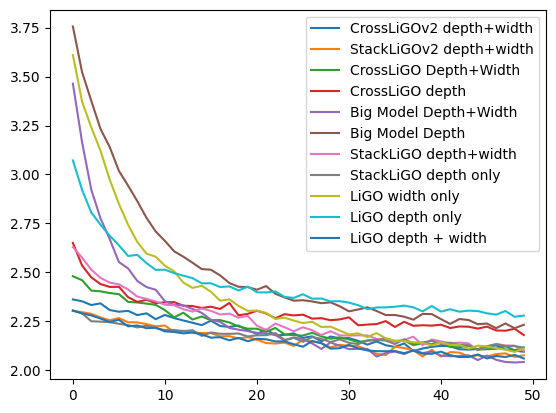

In [52]:
df.plot()

In [53]:
df.to_pickle('Stack_LiGO_curves')